# CenterResnet Starter


I am very new to these concepts so I am trying out by changing this amazing and probably only 3D model related awesome public kernel by Ruslan
https://www.kaggle.com/hocop1/centernet-baseline

Most of the codes are loaned from there . There are other codes that I took from OFT implementation github . But I dont know what is OFT , so I have not yet implemented it . 

My current score is not from this kernel( as there are some errors in this kernel) , but from some simple architecture modification of the original public kernel. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '../input/pku-autonomous-driving/'
os.listdir(PATH)

['car_models_json',
 'test_masks.zip',
 'test_images',
 'test_images.zip',
 'sample_submission.csv',
 'car_models',
 'train.csv',
 'camera.zip',
 'test_masks',
 'train_masks',
 'car_models_json.zip',
 'train_masks.zip',
 'train_images',
 'camera',
 'train_images.zip',
 'car_models.zip']

In [2]:
## Constants
SWITCH_LOSS_EPOCH = 5

# Load data

In [3]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


**ImageId** column contains names of images:

In [4]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

#plt.figure(figsize=(15,8))
#plt.imshow(img);

In [5]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [6]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# Data distributions

In [7]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

#plt.figure(figsize=(15,6))
#sns.countplot(lens);
#plt.xlabel('Number of cars in image');

In [8]:
# plt.figure(figsize=(15,6))
# sns.distplot(reduce(lambda a, b: a + b, [[c['x'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
# # sns.distplot([str2coords(s)[0]['x'] for s in train['PredictionString']]);
# plt.xlabel('x')
# plt.show()

In [9]:
# plt.figure(figsize=(15,6))
# sns.distplot(reduce(lambda a, b: a + b, [[c['y'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
# plt.xlabel('y')
# plt.show()

In [10]:
# plt.figure(figsize=(15,6))
# sns.distplot(reduce(lambda a, b: a + b, [[c['z'] for c in str2coords(s)] for s in train['PredictionString']]), bins=500);
# plt.xlabel('z')
# plt.show()

In [11]:
# plt.figure(figsize=(15,6))
# sns.distplot(reduce(lambda a, b: a + b, [[c['yaw'] for c in str2coords(s)] for s in train['PredictionString']]));
# plt.xlabel('yaw')
# plt.show()

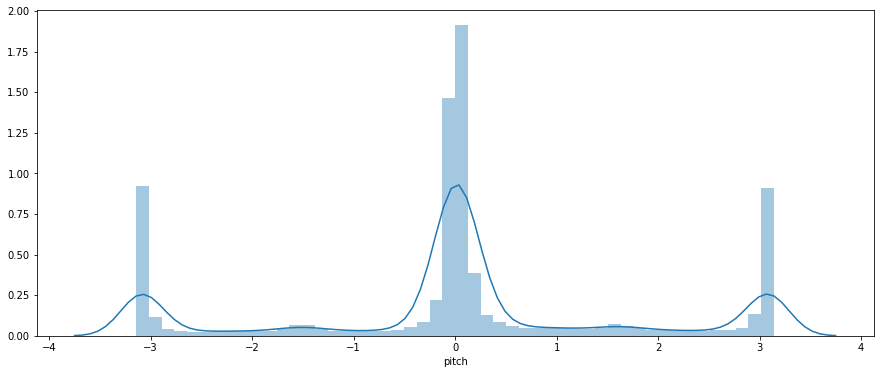

In [12]:
plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[c['pitch'] for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('pitch')
plt.show()

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

In [13]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

# plt.figure(figsize=(15,6))
# sns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));
# plt.xlabel('roll rotated by pi')
# plt.show()

# 2D Visualization

In [14]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

#plt.figure(figsize=(14,14))
#plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
#plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

One point is out of image!

Let's look at the distribution of all points. Image is here just for reference.

In [15]:
# xs, ys = [], []

# for ps in train['PredictionString']:
#     x, y = get_img_coords(ps)
#     xs += list(x)
#     ys += list(y)

# plt.figure(figsize=(18,18))
# plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
# plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

Many points are outside!

Let's look at this distribution "from the sky"

In [16]:
# # Cars points
# xs, ys = [], []
# for ps in train['PredictionString']:
#     coords = str2coords(ps)
#     xs += [c['x'] for c in coords]
#     ys += [c['y'] for c in coords]

# # Road points
# road_width = 6
# road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
# road_ys = [0, 0, 500, 500, 0]

# plt.figure(figsize=(16,16))
# plt.axes().set_aspect(1)
# # View road
# plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
# plt.plot([road_width/2,road_width/2], [0,500], alpha=0.4, linewidth=4, color='white', ls='--')
# plt.plot([-road_width/2,-road_width/2], [0,500], alpha=0.4, linewidth=4, color='white', ls='--')
# # View cars
# plt.scatter(xs, ys, color='red', s=20, alpha=0.2);

Some points are very far away

Scale up

In [17]:
# plt.figure(figsize=(16,16))
# plt.axes().set_aspect(1)
# plt.xlim(-50,50)
# plt.ylim(0,50)

# # View road
# plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
# plt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# plt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# # View cars
# plt.scatter(xs, ys, color='red', s=10, alpha=0.1);

# 3D Visualization
Used code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, but made it one function

In [18]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [19]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [20]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [21]:
# n_rows = 6

# for idx in range(n_rows):
#     fig, axes = plt.subplots(1, 2, figsize=(20,20))
#     img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
#     axes[0].imshow(img)
#     img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
#     axes[1].imshow(img_vis)
#     plt.show()

# Image preprocessing

In [22]:
IMG_WIDTH = 2048
IMG_HEIGHT = IMG_WIDTH // 4
MODEL_SCALE = 8

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

In [23]:
# img0 = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
# img = preprocess_image(img0)

# mask, regr = get_mask_and_regr(img0, train['PredictionString'][0])

# print('img.shape', img.shape, 'std:', np.std(img))
# print('mask.shape', mask.shape, 'std:', np.std(mask))
# print('regr.shape', regr.shape, 'std:', np.std(regr))

# plt.figure(figsize=(16,16))
# plt.title('Processed image')
# plt.imshow(img)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Detection Mask')
# plt.imshow(mask)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Yaw values')
# plt.imshow(regr[:,:,-2])
# plt.show()

# PyTorch Dataset

In [24]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]

In [25]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

Show some generated examples

In [26]:
# img, mask, regr = train_dataset[0]

# plt.figure(figsize=(16,16))
# plt.imshow(np.rollaxis(img, 0, 3))
# plt.show()

# plt.figure(figsize=(16,16))
# plt.imshow(mask)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.imshow(regr[-2])
# plt.show()

In [27]:
BATCH_SIZE = 2

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# PyTorch Model

In [28]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32



def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [30]:
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnet18(pretrained=False)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

       
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        feats8, feats16, feats32 = self.base_model(x)
        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [31]:
# import math
# import torch
# from .optimizer import Optimizer


# class AdamW(Optimizer):
#     r"""Implements AdamW algorithm.

#     The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
#     The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.

#     Arguments:
#         params (iterable): iterable of parameters to optimize or dicts defining
#             parameter groups
#         lr (float, optional): learning rate (default: 1e-3)
#         betas (Tuple[float, float], optional): coefficients used for computing
#             running averages of gradient and its square (default: (0.9, 0.999))
#         eps (float, optional): term added to the denominator to improve
#             numerical stability (default: 1e-8)
#         weight_decay (float, optional): weight decay coefficient (default: 1e-2)
#         amsgrad (boolean, optional): whether to use the AMSGrad variant of this
#             algorithm from the paper `On the Convergence of Adam and Beyond`_
#             (default: False)

#     .. _Adam\: A Method for Stochastic Optimization:
#         https://arxiv.org/abs/1412.6980
#     .. _Decoupled Weight Decay Regularization:
#         https://arxiv.org/abs/1711.05101
#     .. _On the Convergence of Adam and Beyond:
#         https://openreview.net/forum?id=ryQu7f-RZ
#     """

#     def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
#                  weight_decay=1e-2, amsgrad=False):
#         if not 0.0 <= lr:
#             raise ValueError("Invalid learning rate: {}".format(lr))
#         if not 0.0 <= eps:
#             raise ValueError("Invalid epsilon value: {}".format(eps))
#         if not 0.0 <= betas[0] < 1.0:
#             raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
#         if not 0.0 <= betas[1] < 1.0:
#             raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
#         defaults = dict(lr=lr, betas=betas, eps=eps,
#                         weight_decay=weight_decay, amsgrad=amsgrad)
#         super(AdamW, self).__init__(params, defaults)

#     def __setstate__(self, state):
#         super(AdamW, self).__setstate__(state)
#         for group in self.param_groups:
#             group.setdefault('amsgrad', False)

#     def step(self, closure=None):
#         """Performs a single optimization step.

#         Arguments:
#             closure (callable, optional): A closure that reevaluates the model
#                 and returns the loss.
#         """
#         loss = None
#         if closure is not None:
#             loss = closure()

#         for group in self.param_groups:
#             for p in group['params']:
#                 if p.grad is None:
#                     continue

#                 # Perform stepweight decay
#                 p.data.mul_(1 - group['lr'] * group['weight_decay'])

#                 # Perform optimization step
#                 grad = p.grad.data
#                 if grad.is_sparse:
#                     raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
#                 amsgrad = group['amsgrad']

#                 state = self.state[p]

#                 # State initialization
#                 if len(state) == 0:
#                     state['step'] = 0
#                     # Exponential moving average of gradient values
#                     state['exp_avg'] = torch.zeros_like(p.data)
#                     # Exponential moving average of squared gradient values
#                     state['exp_avg_sq'] = torch.zeros_like(p.data)
#                     if amsgrad:
#                         # Maintains max of all exp. moving avg. of sq. grad. values
#                         state['max_exp_avg_sq'] = torch.zeros_like(p.data)

#                 exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
#                 if amsgrad:
#                     max_exp_avg_sq = state['max_exp_avg_sq']
#                 beta1, beta2 = group['betas']

#                 state['step'] += 1
#                 bias_correction1 = 1 - beta1 ** state['step']
#                 bias_correction2 = 1 - beta2 ** state['step']

#                 # Decay the first and second moment running average coefficient
#                 exp_avg.mul_(beta1).add_(1 - beta1, grad)
#                 exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
#                 if amsgrad:
#                     # Maintains the maximum of all 2nd moment running avg. till now
#                     torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
#                     # Use the max. for normalizing running avg. of gradient
#                     denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
#                 else:
#                     denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

#                 step_size = group['lr'] / bias_correction1

#                 p.data.addcdiv_(-step_size, exp_avg, denom)

#         return loss

In [32]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 12 #6

model = CentResnet(8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


In [33]:
img_batch = torch.randn((1,3,512,2048))

In [34]:
#test = model(img_batch.to(device))

In [35]:
model.load_state_dict(torch.load('./weights/model_Resnet.pth'))
model.eval();

In [36]:
def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h
def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    
    
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap


def gaussian_mask(mask):
    xlist, ylist = np.where(mask == 1)
    masklist = [(i,j) for i, j in zip(xlist, ylist)]
    hm = np.zeros(mask.shape) 

    for (y,x) in masklist:
        bbox = np.array([x-0.1, y-0.1, x+0.1, y+0.1])
        h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
        radius = gaussian_radius((h, w))    
        ct = np.array([(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2], dtype=np.float32)
        ct_int = ct.astype(np.int32)
        hm[int(bbox[1]): int(bbox[3]), int(bbox[0]): int(bbox[2])] = 0.9999    
        gm =+ draw_msra_gaussian(hm, ct, 0.7) # np.exp((y-5)/200)

    #plt.figure(figsize=(16,16))
    #plt.imshow(gm, vmin=0, vmax=1)
    #plt.show()
    
    return gm

from tqdm import tqdm
def apply_gaussian(dataset):
    for i in tqdm(range(len(dataset))):
        dataset[i][1] = gaussian_mask(dataset[i][1])    
    return dataset

In [ ]:
train_dataset = apply_gaussian(train_dataset)

 17%|█▋        | 735/4219 [05:22<25:39,  2.26it/s]

# Training

In [ ]:
def criterion(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [ ]:
def train(epoch, history=None):
    model.train()
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        if epoch < SWITCH_LOSS_EPOCH :
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,1)
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5)  
        
        t.set_description(f'train_loss (l={loss:.3f})(m={mask_loss:.2f}) (r={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()

    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}\tMaskLoss: {:.6f}\tRegLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data,
        mask_loss.data,
        regr_loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch,1, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data 

    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    
    print('Dev loss: {:.4f}'.format(valid_loss))

In [ ]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)

In [ ]:
torch.save(model.state_dict(), './modelGaussian'+'.pth')

In [ ]:
history['train_loss'].iloc[100:].plot();

In [ ]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

In [ ]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

# Visualize predictions

In [44]:
# img, mask, regr = dev_dataset[0]

# plt.figure(figsize=(16,16))
# plt.title('Input image')
# plt.imshow(np.rollaxis(img, 0, 3))
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Ground truth mask')
# plt.imshow(mask)
# plt.show()

# output = model(torch.tensor(img[None]).to(device))
# logits = output[0,0].data.cpu().numpy()

# plt.figure(figsize=(16,16))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()

# print(logits)
# plt.figure(figsize=(16,16))
# plt.title('Model predictions thresholded')
# plt.imshow(logits > 0)
# plt.show()

In [45]:
# ## Simple test of probabilities
# act = torch.nn.Sigmoid()
# logtens = torch.from_numpy(logits)
# probs = act(logtens)
# probs = probs[probs>0.03]
# print(probs)

In [46]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, threshold):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > threshold)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [47]:
# import gc

# torch.cuda.empty_cache()
# gc.collect()

# for idx in range(8):
#     img, mask, regr = dev_dataset[idx]
    
#     output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
#     coords_pred = extract_coords(output[0])
#     coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
#     img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
#     fig, axes = plt.subplots(1, 2, figsize=(30,30))
#     axes[0].set_title('Ground truth')
#     axes[0].imshow(visualize(img, coords_true))
#     axes[1].set_title('Prediction')
#     axes[1].imshow(visualize(img, coords_pred))
#     plt.show()

# Evaluation

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
import matplotlib.pyplot as plt
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

#def str2coords(s, names):
#    coords = []
#    for l in np.array(s.split()).reshape([-1, 7]):
#        coords.append(dict(zip(names, l.astype('float'))))
#    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

def print_pr_curve(result_flg, scores, recall_total=1):
    average_precision = average_precision_score(result_flg, scores)
    precision, recall, _ = precision_recall_curve(result_flg, scores)
    recall *= recall_total
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

In [49]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


# validation prediction

In [284]:
def peak(array, threshold1, threshold2):
    (xlist, ylist) = np.where(out[0]>np.sort(out[0].reshape((1,-1)))[0][-200])
    peak_array = array
    maximum = out.max()
    for k in range(len(xlist)):
        idx = 0
        i = xlist[k]
        j = ylist[k]
        try:
            array[i-1,j-1]
            array[i+1,j+1]
        except:
            continue
        if int(array[i,j]>=array[i-1,j]-1)+int(array[i,j]>=array[i+1,j]-1)+\
                int(array[i,j]>=array[i,j-1]-1)+int(array[i,j]>=array[i,j+1]-1) == 4:
            idx += 1
        if idx==1 and array[i,j]>threshold1-2:
            peak_array[i,j]+=(maximum - peak_array[i,j])/2
        #if array[i,j]>threshold1+threshold2: #1.5
        #    pass#peak_array[i,j]+=0.5 #1
    return peak_array

In [276]:
def extract_coords(prediction, threshold1, threshold2):
    logits = peak(prediction[0], threshold1, threshold2)#prediction[0]#peak(prediction[0], threshold1, threshold2)##peak(prediction[0], threshold1, threshold2)
    regr_output = prediction[1:]
    points = np.argwhere(logits > -2)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

In [277]:
threshold1 = -2
threshold2 = 0

In [278]:
# map: 0.10844716601852893 # -2
# map: 0.11908345067814112 # -3
# map: 0.1279842909587167  # -4
# map: 0.13395854895945764 # -5 
# map: 0.1383288800848642  # -6
# map: 0.14158187970998287 # -7

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


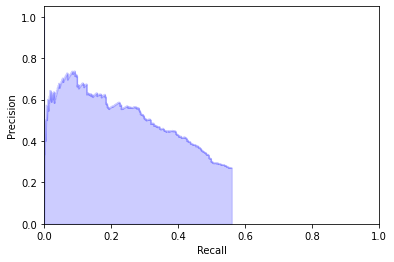

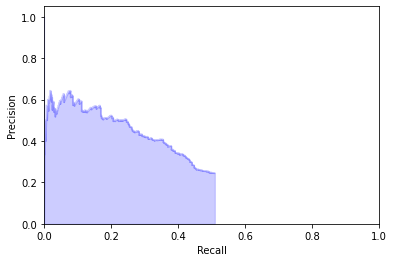

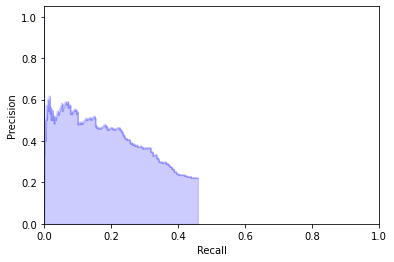

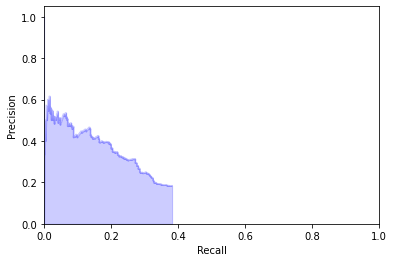

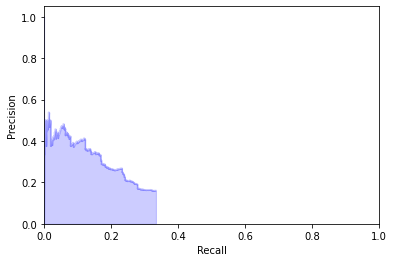

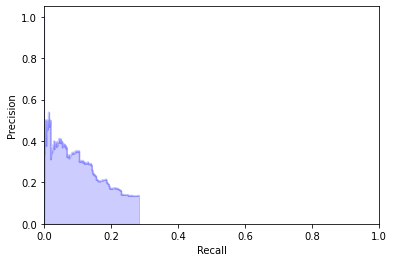

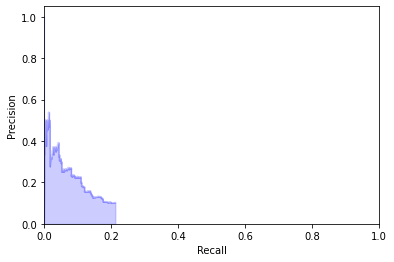

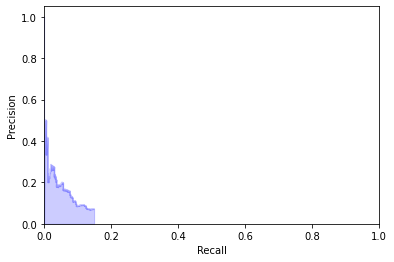

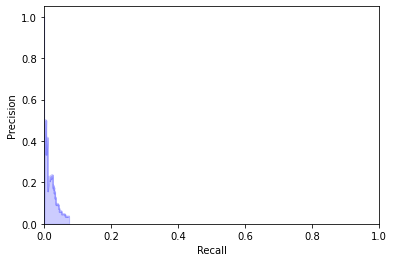

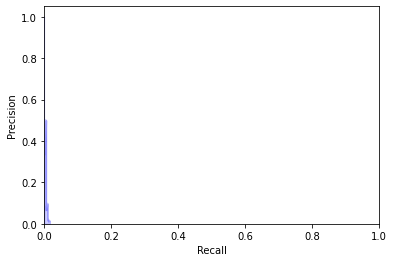

map: 0.11163566827288252


In [285]:
import copy

predictions = []
dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)
model.eval()
for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out, threshold1, threshold2)
        s = coords2str(coords)
        predictions.append(s)
        
df_dev['PredictionString'] = copy.copy(predictions)

valid_df = df_dev
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        print_pr_curve(result_flg, scores, recall)
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)

score = {}
score[str(threshold1)+'_'+str(threshold2)]=map

In [283]:
import copy

predictions = []
dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)
model.eval()
for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out, threshold1, threshold2)
        s = coords2str(coords)
        predictions.append(s)
        
df_dev['PredictionString'] = copy.copy(predictions)

valid_df = df_dev
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        print_pr_curve(result_flg, scores, recall)
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)

score = {}
score[str(threshold1)+'_'+str(threshold2)]=map

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


IndexError: index 64 is out of bounds for axis 0 with size 64

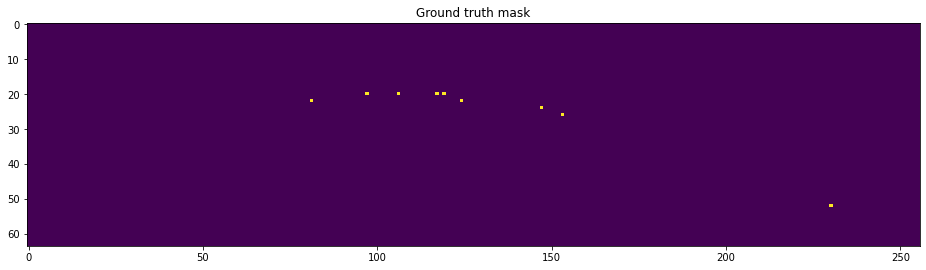

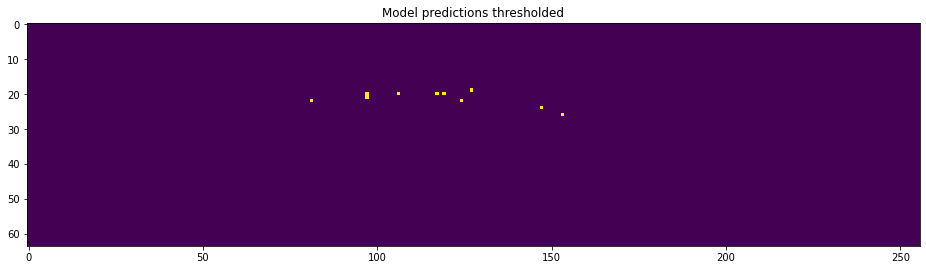

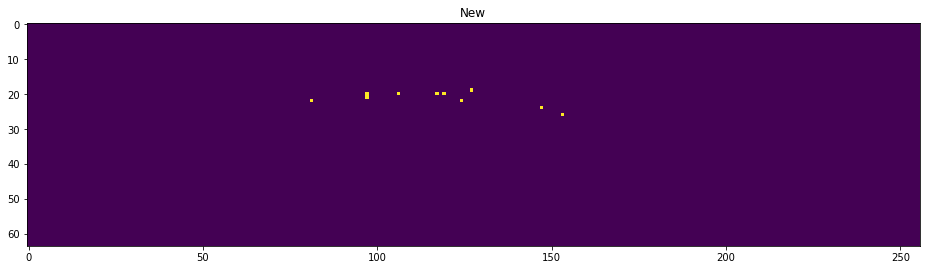

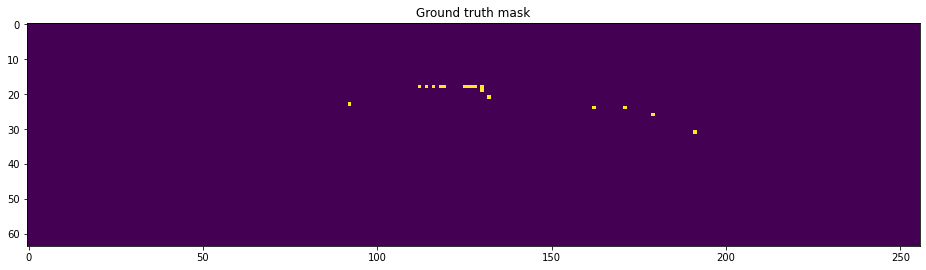

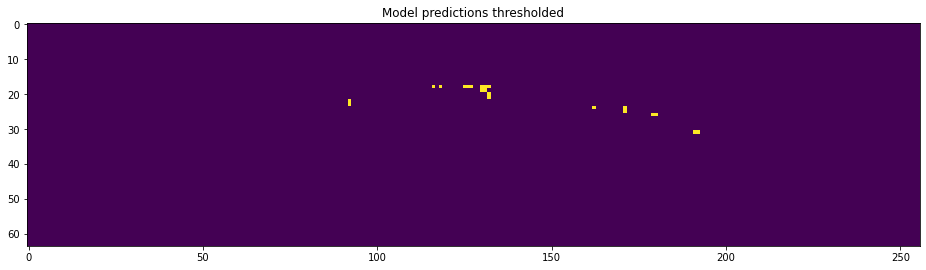

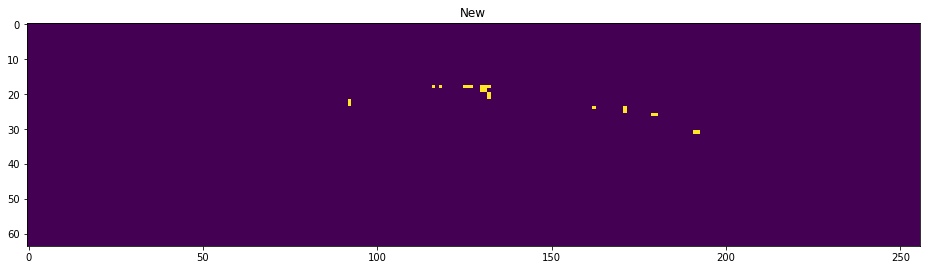

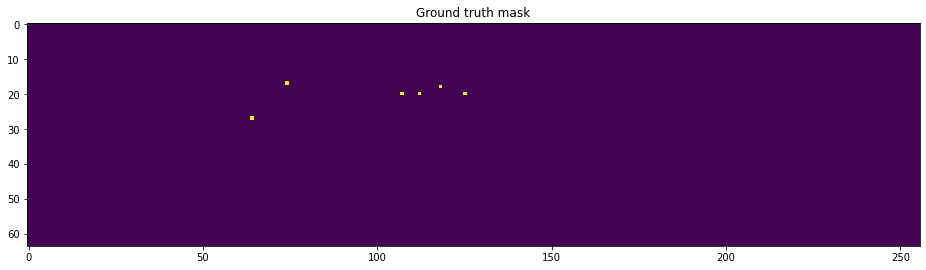

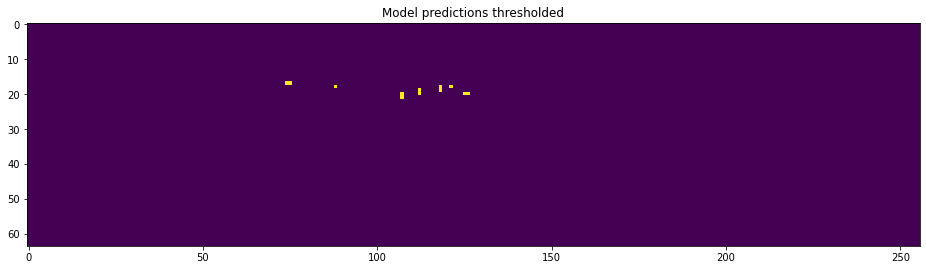

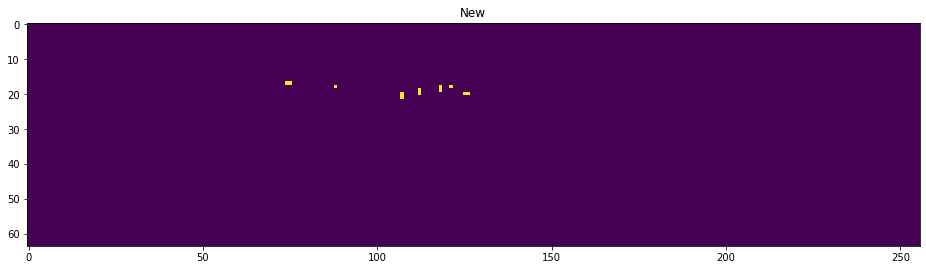

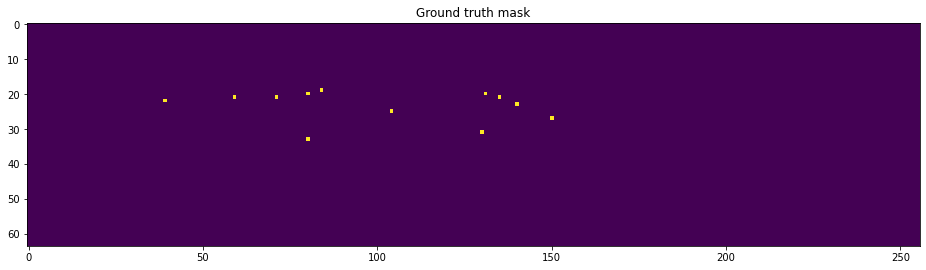

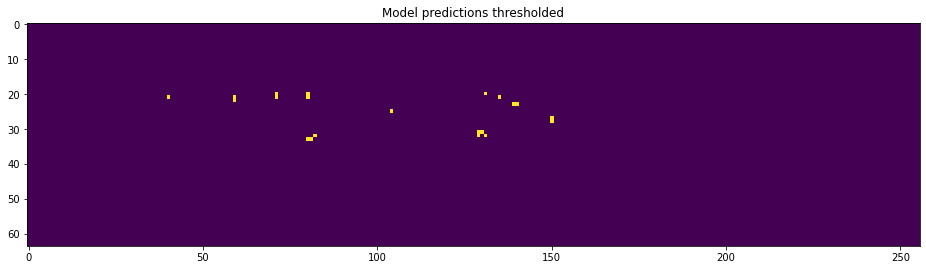

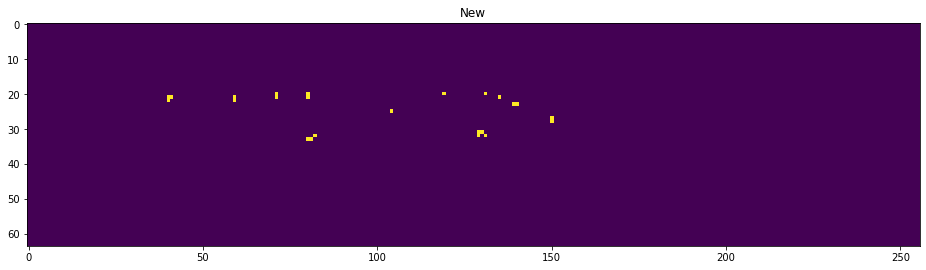

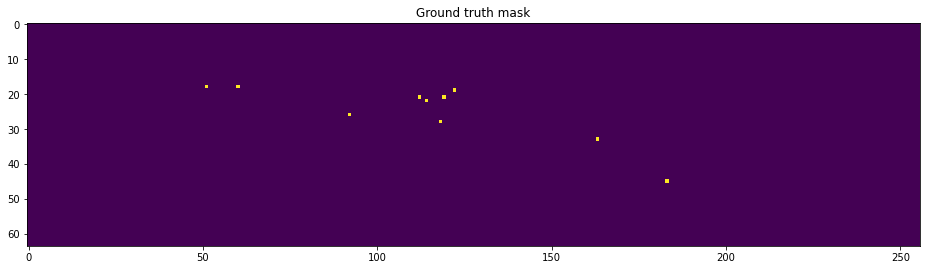

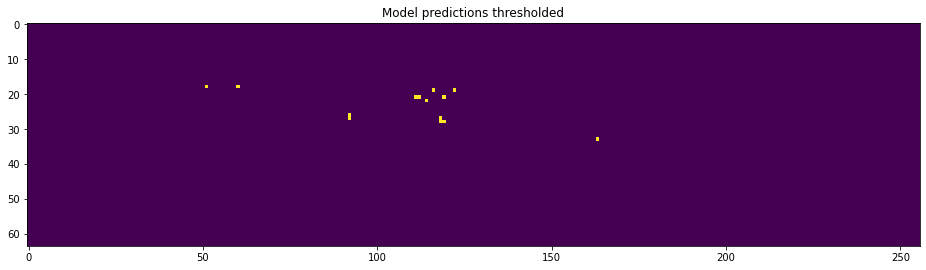

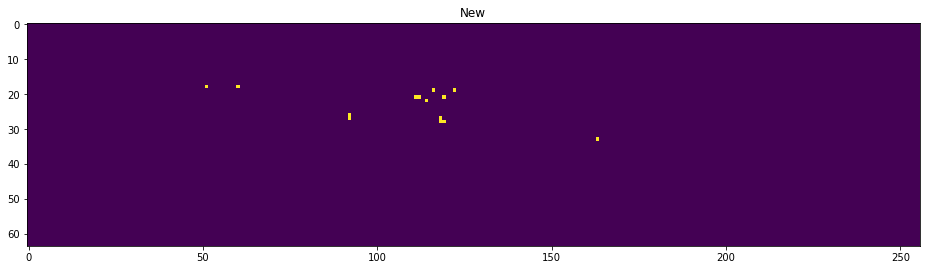

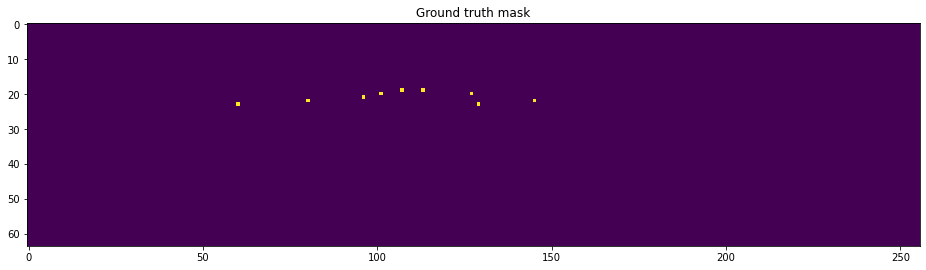

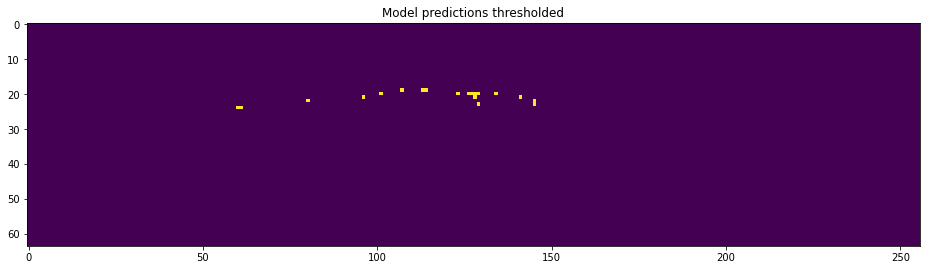

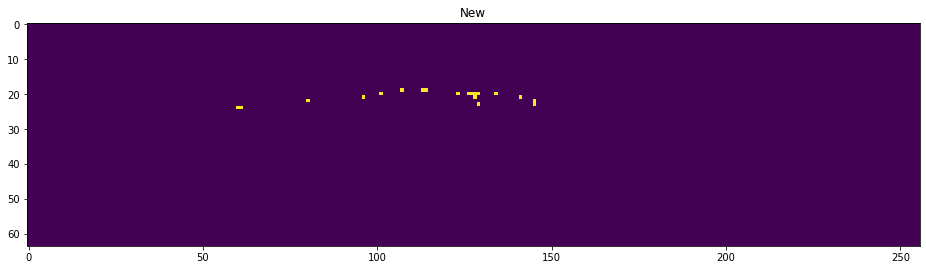

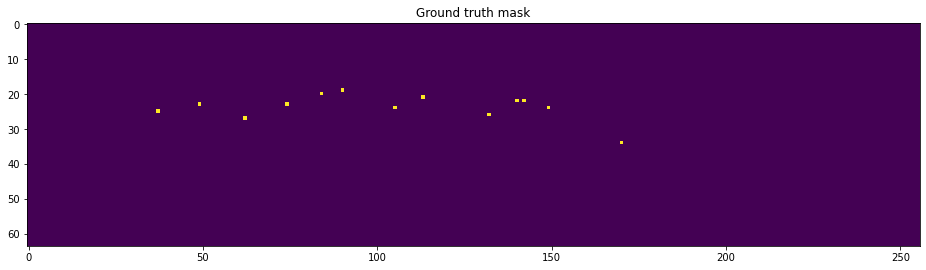

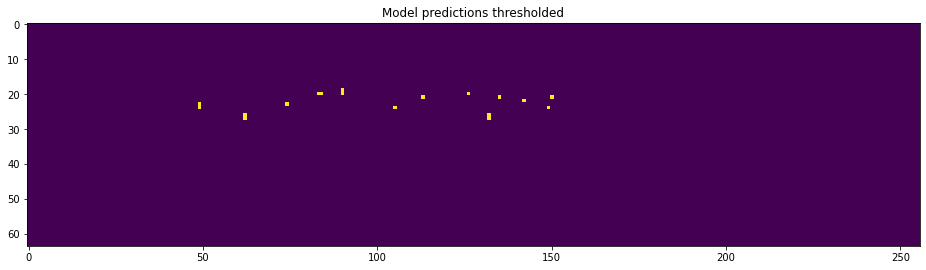

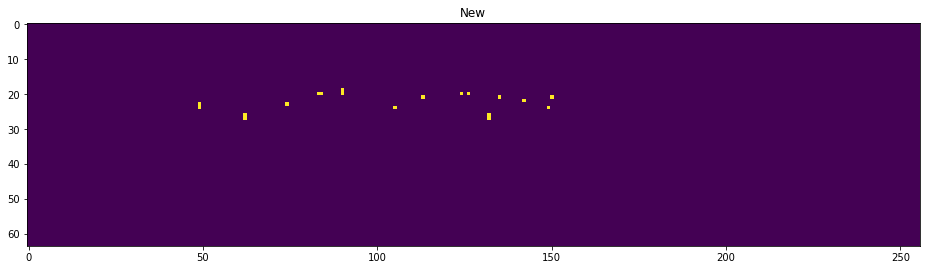

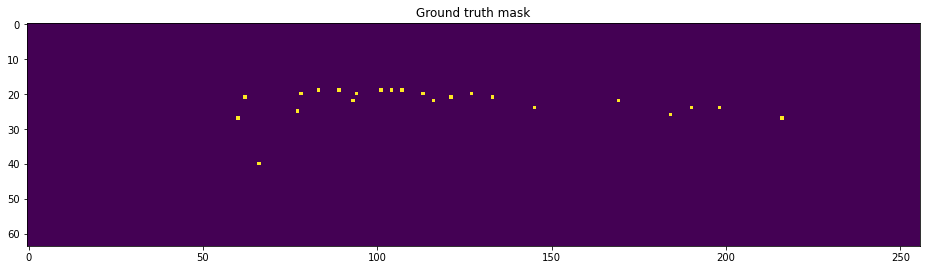

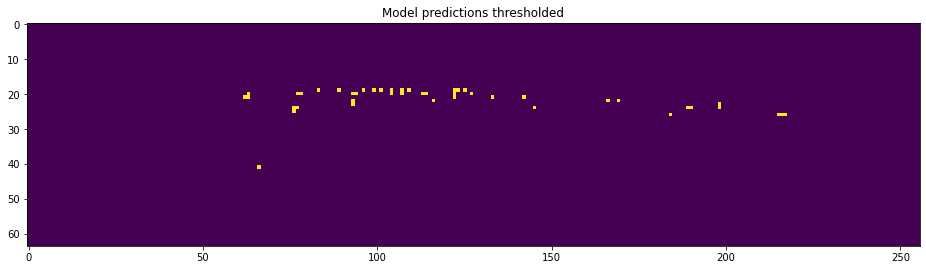

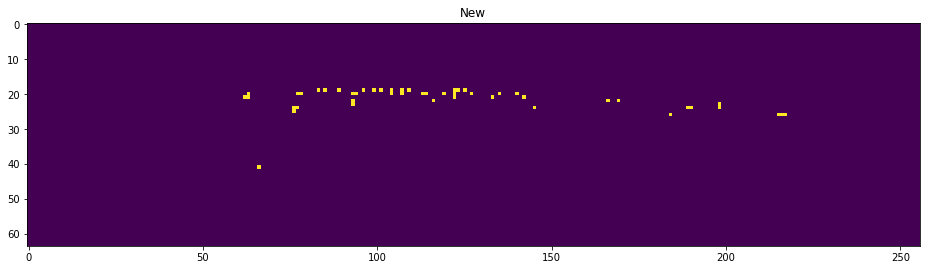

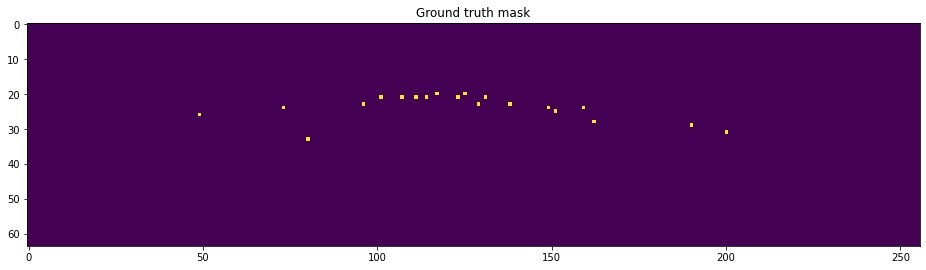

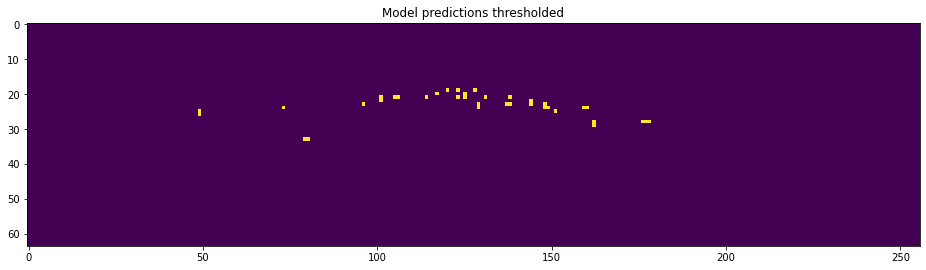

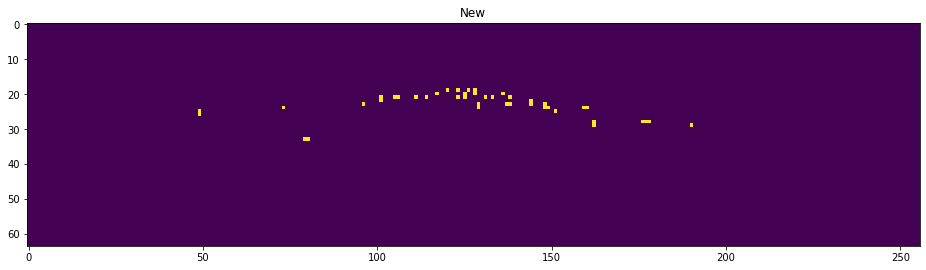

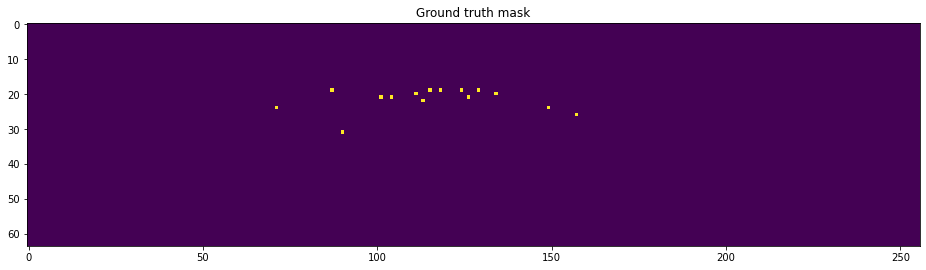

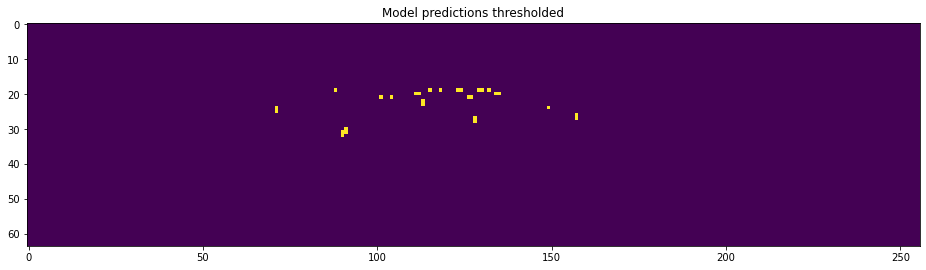

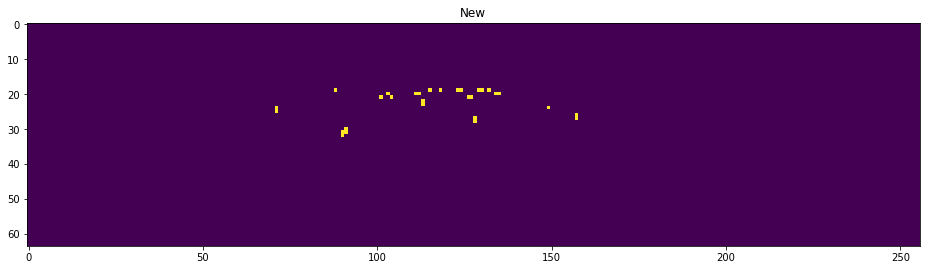

In [282]:
for i in range(40,50):
    img, mask, regr = train_dataset[i]

    #plt.figure(figsize=(16,16))
    #plt.title('Input image')
    #plt.imshow(np.rollaxis(img, 0, 3))
    #plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Ground truth mask')
    plt.imshow(mask)
    plt.show()

    output = model(torch.tensor(img[None]).to(device))
    logits = output[0,0].data.cpu().numpy()

    #plt.figure(figsize=(16,16))
    #plt.title('Model predictions')
    #plt.imshow(logits)
    #plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions thresholded')
    plt.imshow(logits>-2)
    plt.show()
    
    plt.figure(figsize=(16,16))
    plt.title('New')
    plt.imshow(peak(logits,threshold1,threshold2)>-2)
    plt.show()

# Make submission

In [287]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out,threshold1, threshold2)
        s = coords2str(coords)
        predictions.append(s)
        
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions'+'_'+str(threshold1)+'.csv', index=False)
test.head()

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


,ImageId,PredictionString
0,ID_18fb86d04,0.14466952 -0.13116118525529874 -3.10509620805...
1,ID_ce06d4dc1,0.1683209 -0.08619953718700635 -3.094846183555...
2,ID_afe07078f,0.11573092 -3.1159995085006518 -3.094527652608...
3,ID_37caf75aa,0.12981284 0.03811644169798502 -3.087830921756...
4,ID_7655363ca,0.14196698 3.0943143055589406 -3.0859912355714...
